In this notebook there is the usage of the function: <b>dadi.Plotting.plot_1d_comp_multinomial</b>:


This function plot a comparison between a one-dimensional model and data FS. 

In the multinomial method, the model is optimally scaled to match the data. The top plot shows the model and data frequency spectra, while the bottom shows the residuals between model and data. The bottom plot shows the residuals between model and data; a positive residuals means the model predicts too many SNPs in that entry.
The residuals are the properly normalized differences between model and data. Normalization is necessary, because the expected variance in each entry increase with the expected value of that entry.

In [2]:
%run imports.ipynb

In [1]:
import dadi
from dadi import Numerics
from dadi import PhiManip
from dadi import Integration
from dadi import Spectrum

from matplotlib import pyplot as plt
import matplotlib
from matplotlib import pylab

In [3]:
callset = callset_biallel
accessibility_fn = accessibility
contigs = ('3R')

In [4]:
allele_counts = zarr.open('data/phase2_biallel_allele_count.zarr/')
list(allele_counts['3L'].keys())

['AOcol',
 'BFcol',
 'BFgam',
 'CIcol',
 'CMgam',
 'FRgam',
 'GAgam',
 'GHcol',
 'GHgam',
 'GM',
 'GNcol',
 'GNgam',
 'GQgam',
 'GW',
 'KE',
 'UGgam']

In [6]:
outgroup_alleles = h5py.File('data/outgroup_alleles_phase2.h5', mode = 'r')
annotation = zarr.open('data/ag1000g.phase2.ar1.pass.biallelic_snpeff/')

In [212]:
def two_epoch(params, ns, pts):
    nu1, T1, p_misid = [1, 1, 0.01]

    xx = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx)

    phi = Integration.one_pop(phi, xx, T1, nu1)

    fs = Spectrum.from_phi(phi, ns, (xx,))
    return (1 - p_misid) * fs + p_misid * dadi.Numerics.reverse_array(fs)


def three_epoch(params, ns, pts):
    nu1, nu2, T1, T2, p_misid = [1, 1, 1, 1, 0.01]

    xx = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx)

    phi = Integration.one_pop(phi, xx, T1, nu1)
    phi = Integration.one_pop(phi, xx, T2, nu2)

    fs = Spectrum.from_phi(phi, ns, (xx,))
    return (1 - p_misid) * fs + p_misid * dadi.Numerics.reverse_array(fs)

def four_epoch(params, ns, pts):
    nu1, nu2, nu3, T1, T2, T3, p_misid = [1, 1, 1, 1, 1, 1, 0.01]

    xx = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx)

    phi = Integration.one_pop(phi, xx, T1, nu1)
    phi = Integration.one_pop(phi, xx, T2, nu2)
    phi = Integration.one_pop(phi, xx, T3, nu3)

    fs = Spectrum.from_phi(phi, ns, (xx,))
    return (1 - p_misid) * fs + p_misid * dadi.Numerics.reverse_array(fs)

def three_exp(params, ns, pts):
    nu1, nu2, T1, T2, p_misid = [1, 1, 1, 1, 0.01]

    xx = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx)

    phi = Integration.one_pop(phi, xx, T1, nu1)
    nu_func = lambda t: numpy.exp(numpy.log(nu2) * t/T )
    phi = Integration.one_pop(phi, xx, T2, nu_func)

    fs = Spectrum.from_phi(phi, ns, (xx,))
    return (1 - p_misid) * fs + p_misid * dadi.Numerics.reverse_array(fs)
simul = {'two_epoch': two_epoch, 'three_epoch': three_epoch, 'three_exp': three_exp, 'four_epoch': four_epoch}

def implem(pop_name, k, fs, pts):


    if k == "two_epoch":
        params=[1, 1, 0.01]
        lower_bound=[0.1, 0.01, 0.001]
        upper_bound=[100, 10, 0.1]

    elif k == "three_epoch" or k == "three_exp":
        params=[1, 1, 1, 1, 0.01]
        lower_bound=[0.1, 0.1, 0.01, 0.01, 0.001]
        upper_bound=[100, 100, 10, 10, 0.1]

    elif k == "four_epoch":
        params=[1, 1, 1, 1, 1, 1, 0.01]
        lower_bound=[0.1, 0.1, 0.1, 0.01, 0.01, 0.01, 0.001]
        upper_bound=[100, 100, 100, 10, 10, 10, 0.1]


    func = simul[k]
    ns = fs.sample_sizes
    func_ex = dadi.Numerics.make_extrap_log_func(func)

    l = list()
    for i in range(50): ##prima era 50
        p0 = dadi.Misc.perturb_params(params, fold=1.5, lower_bound=lower_bound, upper_bound=upper_bound)

        popt = dadi.Inference.optimize_log(p0, fs, func_ex, pts, lower_bound=lower_bound, upper_bound=upper_bound,
                                           verbose=len(params), maxiter=300, multinom=True) #verbose era 0
        model = func_ex(popt, ns, pts)
        ll_opt = dadi.Inference.ll_multinom(model, fs)
        summary = [float(ll_opt), np.array(popt).tolist(), model]
        l.append(summary)
        ###print (popt)

    array_l = np.asarray(l, dtype=object)
    #best = [ll_opt, [params]]
    best = array_l[np.argmax(array_l[:, 0], axis=0), :2]
    print ('questo è best:', best)
    print ('questo è best:', best.size)
    model = array_l[np.argmax(array_l[:, 0], axis=0), -1]
    theta0 = dadi.Inference.optimal_sfs_scaling(model, fs)
    Na = (theta0 / 30001805) / (4. * 3.5e-9)
    generation = 0.09



    with open('dadi/output_files/%s_%s.txt' % (k,pop_name),
              'w') as outf:
        writer = csv.writer(outf, delimiter='\t')

        if k == "two_epoch":

            N1 = best[1][0] * Na
            T1 = best[1][1] * (2 * Na * generation)

            header = ['ll_opt', 'theta', 'Na', 'N1', 'T1', 'parameters']
            writer.writerow(header)
            row = [best[0], theta0, Na, N1, T1, best[1]]
            writer.writerow(row)

        elif k == "three_epoch" or k == "three_exp":

            N1 = best[1][0] * Na
            N2 = best[1][1] * Na
            
            T1 = best[1][0] * (2 * Na * generation)
            T2 = best[1][1] * (2 * Na * generation)
            header = ['ll_opt', 'theta', 'Na', 'N1', 'N2', 'T1(lenght)', 'T2', 'parameters']
            writer.writerow(header)
            row = [best[0], theta0, Na, N1, N2, T1, T2, best[1]]
            writer.writerow(row)

        elif k == "four_epoch":

            N1 = best[1][0] * Na
            N2 = best[1][1] * Na
            N3 = best[1][2] * Na
            T1 = best[1][3] * (2 * Na * generation)
            T2 = best[1][4] * (2 * Na * generation)
            T3 = best[1][5] * (2 * Na * generation)

            header = ['ll_opt', 'theta', 'Na', 'N1', 'N2', 'N3' 'T1(lenght)', 'T2(lenght)', 'T3', 'parameters']
            writer.writerow(header)
            row = [best[0], theta0, Na, N1, N2, T1, T2, best[1]]
            writer.writerow(row)


    fig, ax = plt.subplots(figsize = (12,7))
    ax.set_title('Dadi %s model for %s' % (k, pop_name))
    ax.set_ylabel('log(count of sites)')
    ax.set_xlabel('Population Frequency')
    sns.despine(ax=ax, offset=10)
    dadi.Plotting.plot_1d_comp_multinom(model, fs)
    fig.savefig('dadi/plot/%s_%s.png' % (k, pop_name))

In [230]:
df = etl.fromcsv("dadi/sf_single/KE.tab", delimiter=" ")
fs = [int(float(i)) for i in df[1]]

In [231]:
fs = dadi.Spectrum(fs)
sz = fs.sample_sizes[0]
pts = np.array([sz + 30, sz + 40, sz + 50])
sz, pts

(94, array([124, 134, 144]))

13791   , -41864.3    , array([ 1.32628    ,  0.695419   ,  0.00517654 ])
13794   , -41864.3    , array([ 2.32654    ,  2.58732    ,  0.0192047  ])
13797   , -41864.3    , array([ 2.32654    ,  2.58732    ,  0.0192239  ])
13800   , -41864.3    , array([ 2.39409    ,  0.734948   ,  0.0113093  ])
13803   , -41864.3    , array([ 2.39169    ,  0.734948   ,  0.0113093  ])
13806   , -41864.3    , array([ 1.74042    ,  0.542561   ,  0.00500704 ])
13809   , -41864.3    , array([ 1.94354    ,  0.585865   ,  0.00918215 ])
13812   , -41864.3    , array([ 1.94354    ,  0.585865   ,  0.00919134 ])
13815   , -41864.3    , array([ 0.661576   ,  0.492446   ,  0.0214585  ])
13818   , -41864.3    , array([ 0.660914   ,  0.492446   ,  0.0214585  ])
13821   , -41864.3    , array([ 0.35973    ,  1.43793    ,  0.00976512 ])
13824   , -41864.3    , array([ 0.870018   ,  1.2723     ,  0.00519531 ])
13827   , -41864.3    , array([ 0.870018   ,  1.2723     ,  0.0052005  ])
13830   , -41864.3    , array([ 0.9985

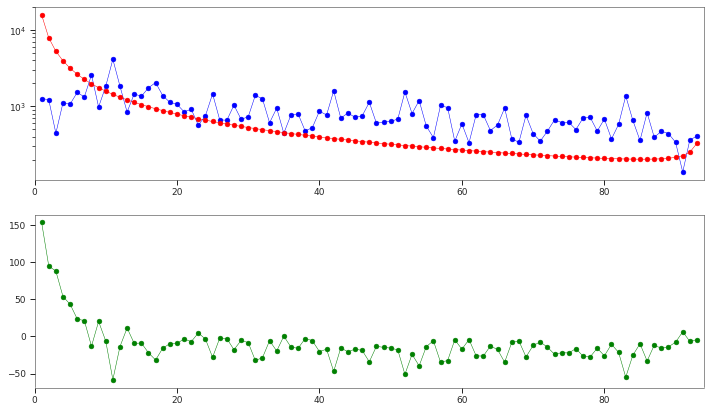

In [215]:
l = implem('KE', "two_epoch", fs, pts)

8718    , -99921.3    , array([ 1.01609    ,  0.675231   ,  0.0226883  ])
8721    , -99921.3    , array([ 1.01609    ,  0.675231   ,  0.022711   ])
8724    , -99921.3    , array([ 1.33513    ,  1.36337    ,  0.00477118 ])
8727    , -99921.3    , array([ 1.33379    ,  1.36337    ,  0.00477118 ])
8730    , -99921.3    , array([ 1.43615    ,  1.15559    ,  0.0279406  ])
8733    , -99921.3    , array([ 1.23665    ,  2.27194    ,  0.00854462 ])
8736    , -99921.3    , array([ 1.23665    ,  2.27194    ,  0.00855317 ])
8739    , -99921.3    , array([ 1.4777     ,  0.821265   ,  0.0140078  ])
8742    , -99921.3    , array([ 1.47622    ,  0.821265   ,  0.0140078  ])
8745    , -99921.3    , array([ 2.51393    ,  1.45895    ,  0.0135751  ])
8748    , -99921.3    , array([ 0.75869    ,  1.13103    ,  0.00381736 ])
8751    , -99921.3    , array([ 0.75869    ,  1.13103    ,  0.00382118 ])
8754    , -99921.3    , array([ 0.887949   ,  1.48457    ,  0.0112713  ])
8757    , -99921.3    , array([ 0.8870

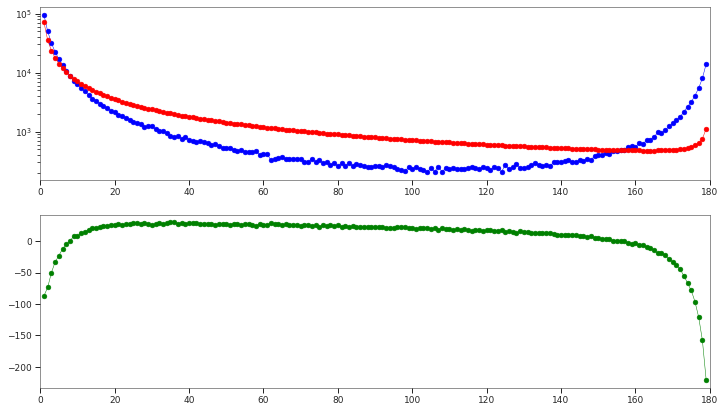

In [164]:
df = etl.fromcsv("dadi/sf_single/GW.tab", delimiter=" ")
fs = [int(float(i)) for i in df[1]]
fs = dadi.Spectrum(fs)
sz = fs.sample_sizes[0]
pts = np.array([sz + 30, sz + 40, sz + 50])
l = implem('GW', "two_epoch", fs, pts)

8970    , -62121.6    , array([ 0.707626   ,  0.809421   ,  0.00994329 ])
8973    , -62121.6    , array([ 0.481528   ,  0.377821   ,  0.00844084 ])
8976    , -62121.6    , array([ 0.481528   ,  0.377821   ,  0.00844929 ])
8979    , -62121.6    , array([ 2.15385    ,  2.1534     ,  0.00660248 ])
8982    , -62121.6    , array([ 2.1517     ,  2.1534     ,  0.00660248 ])
8985    , -62121.6    , array([ 0.735931   ,  1.58074    ,  0.010467   ])
8988    , -62121.6    , array([ 0.790666   ,  0.587503   ,  0.00781152 ])
8991    , -62121.6    , array([ 0.790666   ,  0.587503   ,  0.00781933 ])
8994    , -62121.6    , array([ 0.761103   ,  2.13136    ,  0.0112492  ])
8997    , -62121.6    , array([ 0.760342   ,  2.13136    ,  0.0112492  ])
9000    , -62121.6    , array([ 0.521461   ,  0.809586   ,  0.00640472 ])
9003    , -62121.6    , array([ 0.808519   ,  0.65927    ,  0.00381222 ])
9006    , -62121.6    , array([ 0.808519   ,  0.65927    ,  0.00381604 ])
9009    , -62121.6    , array([ 1.9998

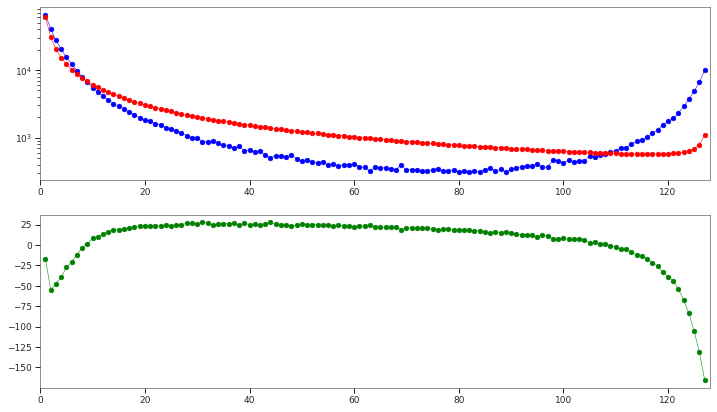

In [165]:
df = etl.fromcsv("dadi/sf_single/GM.tab", delimiter=" ")
fs = [int(float(i)) for i in df[1]]
fs = dadi.Spectrum(fs)
sz = fs.sample_sizes[0]
pts = np.array([sz + 30, sz + 40, sz + 50])
l = implem('GM', "two_epoch", fs, pts)

14040   , -60285.4    , array([ 2.38146    ,  2.13934    ,  0.00985637 ])
14043   , -60285.4    , array([ 2.37908    ,  2.13934    ,  0.00985637 ])
14046   , -60285.4    , array([ 0.505826   ,  0.54265    ,  0.0201378  ])
14049   , -60285.4    , array([ 1.39466    ,  0.844325   ,  0.00459776 ])
14052   , -60285.4    , array([ 1.39466    ,  0.844325   ,  0.00460236 ])
14055   , -60285.4    , array([ 1.51205    ,  1.3451     ,  0.0189204  ])
14058   , -60285.4    , array([ 1.51054    ,  1.3451     ,  0.0189204  ])
14061   , -60285.4    , array([ 2.40698    ,  2.47306    ,  0.0238606  ])
14064   , -60285.4    , array([ 0.428454   ,  1.34352    ,  0.0234832  ])
14067   , -60285.4    , array([ 0.428454   ,  1.34352    ,  0.0235067  ])
14070   , -60285.4    , array([ 2.51457    ,  1.75016    ,  0.0177384  ])
14073   , -60285.4    , array([ 2.51205    ,  1.75016    ,  0.0177384  ])
14076   , -60285.4    , array([ 0.446699   ,  0.818252   ,  0.0127032  ])
14079   , -60285.4    , array([ 0.3955

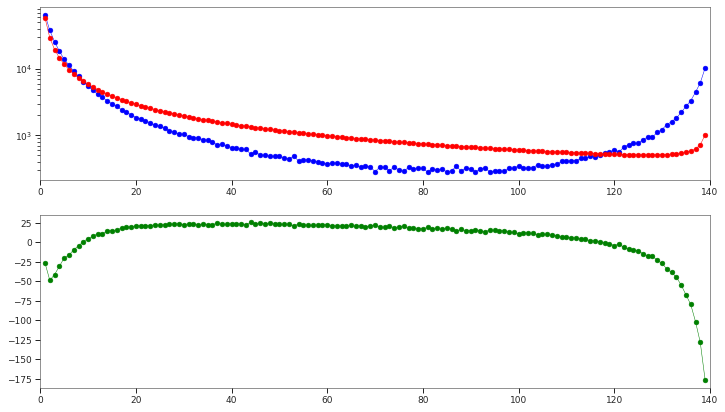

In [220]:
df = etl.fromcsv("dadi/sf_single/CIcol.tab", delimiter=" ")
fs = [int(float(i)) for i in df[1]]
fs = dadi.Spectrum(fs)
sz = fs.sample_sizes[0]
pts = np.array([sz + 30, sz + 40, sz + 50])
l = implem('CIcol', "two_epoch", fs, pts)

-------------------------------------